# Tracking a High-Speed Train under Biased Process Dynamics

In [200]:
import numpy as np
import matplotlib.pyplot as plt

### Kalman Filter Implementation and Data Uploading

In [201]:
X0_0 = np.array([[2], [0]])
P0_0 = np.array([[100, 0], [0, 100]])

data_path = 'data/GPS.txt'
z = np.loadtxt(data_path)
N = len(z)

T = 2.0
sigma_a_sq = 0.2**2
sigma_eta_sq = 20.0**2

Phi = np.array([[1, T], [0, 1]])
G = np.array([[0.5 * T**2], [T]])
H = np.array([[1, 0]])

Ri = np.array([[sigma_eta_sq]])

def run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0, q_bias = None):
    Q = G @ G.T * sigma_a_sq

    X_filt_prev = X0_0
    P_filt_prev = P0_0

    X_predicted = np.zeros((N, 2, 1))
    P_predicted = np.zeros((N, 2, 2))
    X_filtered = np.zeros((N, 2, 1))
    P_filtered = np.zeros((N, 2, 2))

    K_history = np.zeros((N, 2, 1))
    
    X_predicted_ahead = np.zeros(N)

    for i in range(N):
        # prediction stage
        X_pred = Phi @ X_filt_prev
        if q_bias is not None:
            X_pred += G @ q_bias

        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        # filtration stage
        residual = z[i] - H @ X_pred
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + Ri)
        X_filt = X_pred + K @ residual
        I = np.eye(2)
        P_filt = (I - K @ H) @ P_pred

        # save data
        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
        K_history[i] = K
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
        
    return X_filtered, P_filtered, X_predicted, P_predicted, K_history, X_predicted_ahead

## Step I: Filtering the data
We run the Kalman filter on the GPS data using the initial model, which does not account for the constant acceleration. We then plot the results to observe the filter's performance.

In [202]:
X_filtered, P_filtered, X_predicted, P_predicted, K_history, _ = run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0)

### Plot: Position and Velocity Estimates vs. Ground Truth

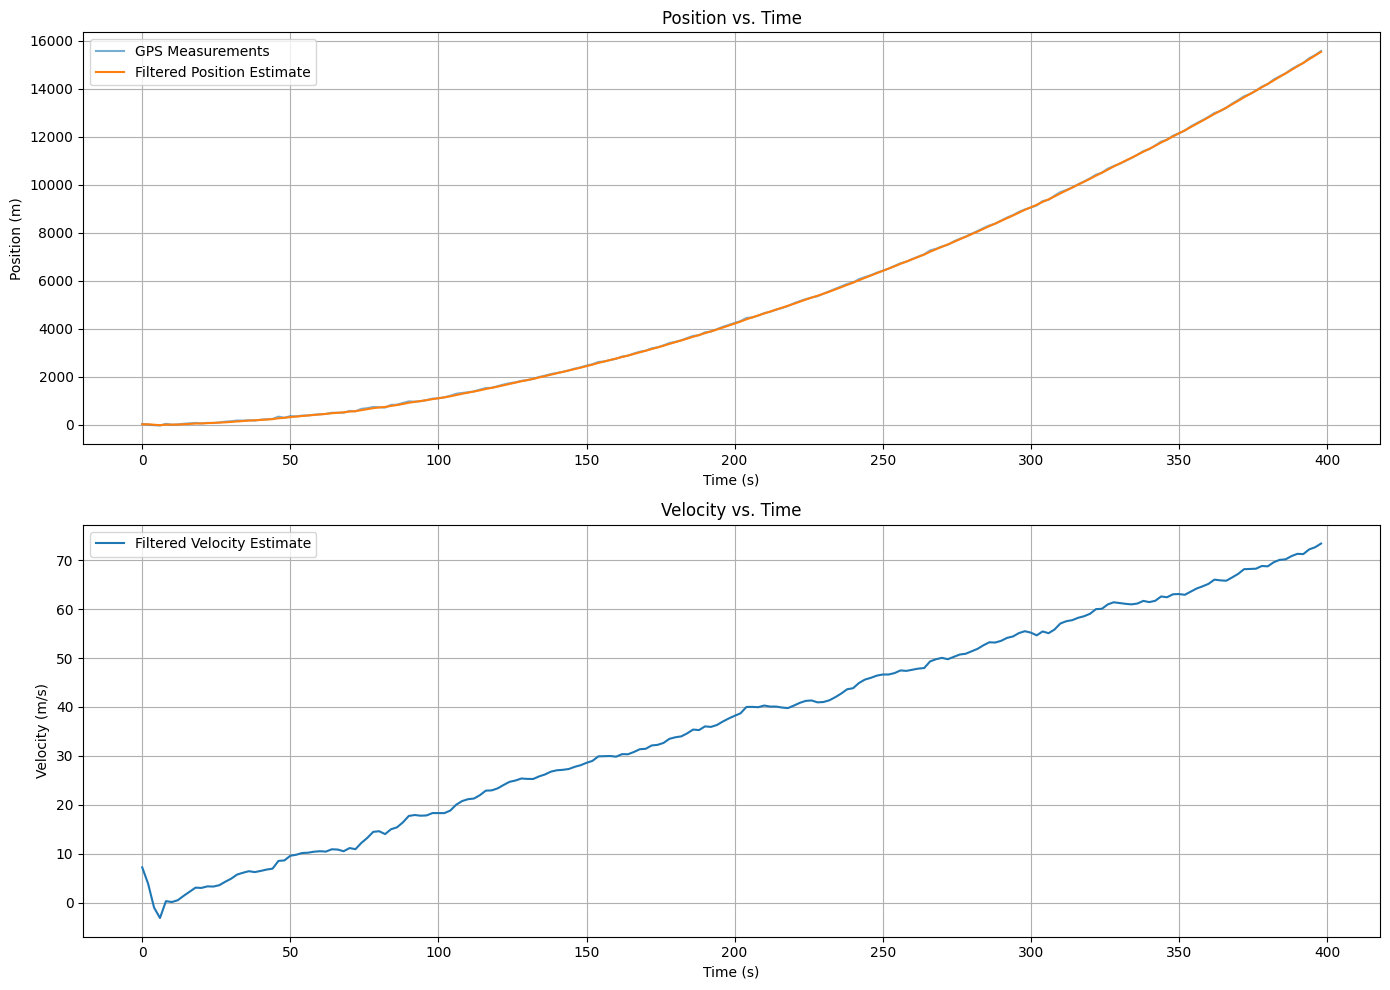

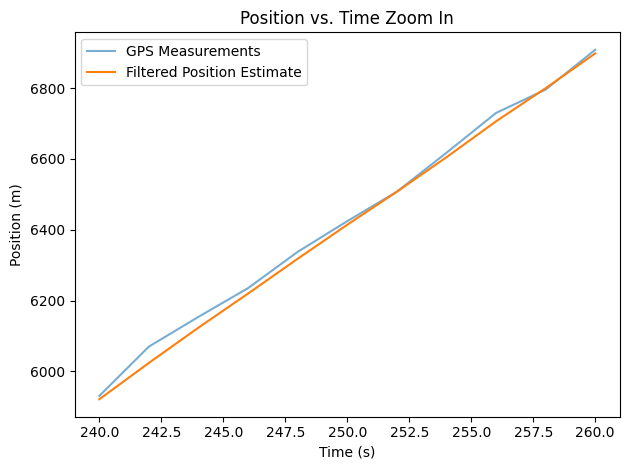

In [203]:
time = np.arange(N) * T

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(time, z, label='GPS Measurements', alpha=0.6)
plt.plot(time, X_filtered[:, 0], '-', label='Filtered Position Estimate')
plt.title('Position vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, X_filtered[:, 1], '-', label='Filtered Velocity Estimate')
plt.title('Velocity vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Zoom in
start_idx = 120
end_idx = 130
t_cut = time[start_idx:end_idx + 1]
z_cut = z[start_idx:end_idx + 1]
x_cut = X_filtered[start_idx:end_idx + 1, 0]

plt.figure()
plt.plot(t_cut, z_cut, label='GPS Measurements', alpha=0.6)
plt.plot(t_cut, x_cut, '-', label='Filtered Position Estimate')
plt.title('Position vs. Time Zoom In')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.tight_layout()

## Step II: Checking residuals for signs of bias

We now analyze the filter residuals to statistically confirm the presence of a bias. For a well-behaved filter, the residuals should resemble white noise with a zero mean.

In [204]:
residuals = z - X_predicted[:, 0, 0]

mean_residual = np.mean(residuals)
print(f'Mean of the residuals: {mean_residual:.4f}')

Mean of the residuals: 20.7900


### Plot: Residuals vs. Predicted Standard Deviation

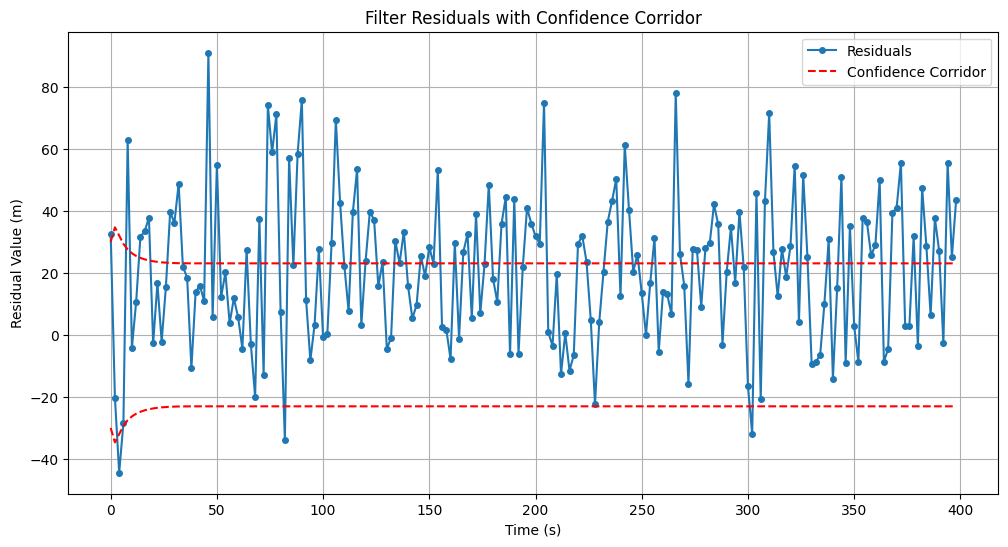

In [205]:
S = np.zeros(N)
for i in range(N):
    S[i] = (H @ P_predicted[i] @ H.T + Ri)[0, 0]

std_S = np.sqrt(S)

plt.figure(figsize=(12, 6))
plt.plot(time, residuals, 'o-', markersize=4, label='Residuals')
plt.plot(time, std_S, 'r--', label='Confidence Corridor')
plt.plot(time, -std_S, 'r--')
plt.title('Filter Residuals with Confidence Corridor')
plt.xlabel('Time (s)')
plt.ylabel('Residual Value (m)')
plt.legend()
plt.grid(True)
plt.show()

For an optimal Kalman filter, the filter residuals should behave like white noise - that is, they should have zero mean and be uncorrelated over time

Here is non zero mean!

The analysis confirms a bias. The mean of the residuals is significantly positive, not close to zero. This demonstrates that the filter is systematically wrong.  
?? and also overconfident in its estimates; the actual errors are much larger than the filter predicts.

## Step III: Correcting the bias

We are told the system has a constant drift (acceleration) `q = 0.2`. To incorporate this into the filter, we must modify the prediction step. 

In [206]:
# Define the bias and re-run the filter
q_bias = np.array([[0.2]])
X_filtered_corr, P_filtered_corr, X_predicted_corr, P_predicted_corr, _, _ = run_kalman_filter(z, N, sigma_a_sq, X0_0, P0_0, q_bias)

### Rechecking Residuals

Mean of the corrected residuals: -1.1453


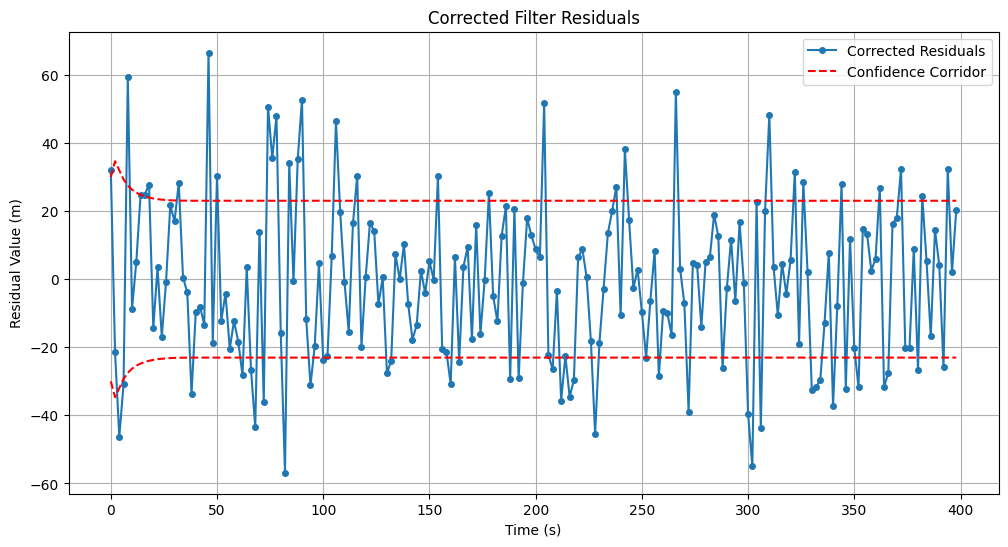

In [207]:
# Re-calculate and plot residuals for the corrected filter
residuals_corr = z - X_predicted_corr[:, 0, 0]
S_corr = np.zeros(N)
for i in range(N):
    S_corr[i] = (H @ P_predicted_corr[i] @ H.T + Ri)[0, 0]
std_S_corr = np.sqrt(S_corr)

mean_residual_corr = np.mean(residuals_corr)
print(f'Mean of the corrected residuals: {mean_residual_corr:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(time, residuals_corr, 'o-', markersize=4, label='Corrected Residuals')
plt.plot(time, std_S_corr, 'r--', label='Confidence Corridor')
plt.plot(time, -std_S_corr, 'r--')
plt.title('Corrected Filter Residuals')
plt.xlabel('Time (s)')
plt.ylabel('Residual Value (m)')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Corrected Filter
With the bias correction, the filter's performance is restored. The mean of the residuals is now very close to zero, and the residuals themselves remain well within the confidence corridor. This indicates that the modified model now accurately captures the train's dynamics.

## Step IV: Analyzing the true error when ignoring bias of state noise

When the filter ignores the bias, its covariance matrix `P` is inaccurate because it only accounts for random error, not systematic error. We will now calculate the systematic error propagation (`μ`) and combine it with `P` to find the true total error of the original, uncorrected filter.

In [208]:
mu_filt = np.zeros((N, 2, 1))
mu_pred = np.zeros((N, 2, 1))
mu_filt_prev = np.array([[0], [0]])
q_ignored_bias = np.array([[0.2]])

for i in range(N):
    mu_pred[i] = Phi @ mu_filt_prev + G @ q_ignored_bias
    
    K = K_history[i]
    mu_filt[i] = (np.eye(2) - K @ H) @ mu_pred[i]
    
    mu_filt_prev = mu_filt[i]

std_from_filter_P = np.sqrt(P_filtered[:, 0, 0])
true_error_std = np.sqrt(P_filtered[:, 0, 0] + mu_filt[:, 0, 0]**2)
std_meas_noise = np.full(N, np.sqrt(sigma_eta_sq))

### Plot: True Error vs. Filter's Estimated Error


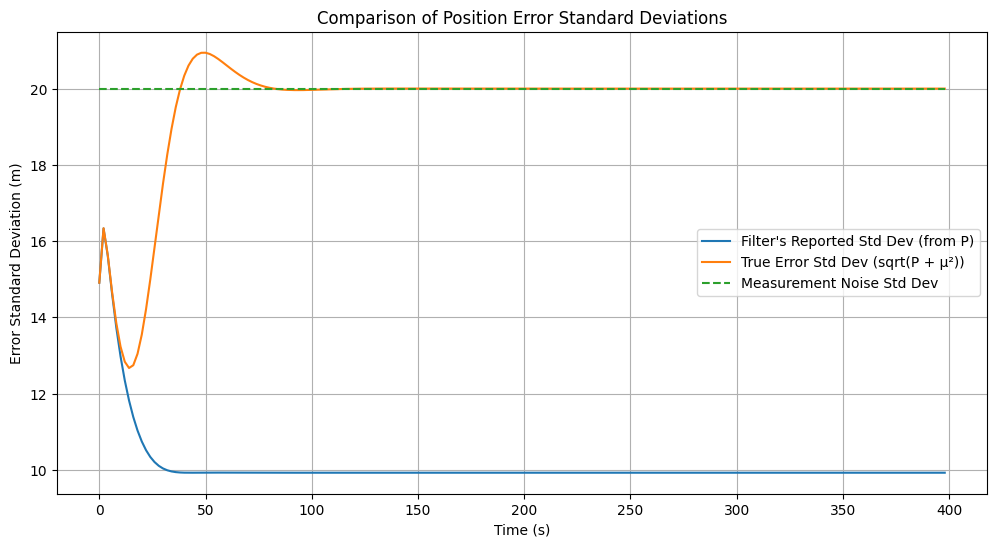

In [209]:
plt.figure(figsize=(12, 6))
plt.plot(time, std_from_filter_P, label="Filter's Reported Std Dev (from P)")
plt.plot(time, true_error_std, label="True Error Std Dev (sqrt(P + μ²))")
plt.plot(time, std_meas_noise, '--', label="Measurement Noise Std Dev")

plt.title('Comparison of Position Error Standard Deviations')
plt.xlabel('Time (s)')
plt.ylabel('Error Standard Deviation (m)')
plt.legend()
plt.grid(True)
plt.show()

### Analysis of True Error

The filter's calculated covariance matrices `P` only represent the random component of the error, but ignore the systematic bias component.

The plot reveals a critical insight. The biased filter's reported standard deviation quickly drops, suggesting it is very confident. However, the true error, which includes the growing systematic bias `μ`, continuously increases. 

The filter is only effective for the first ~30 seconds while its true error is less than the measurement noise. After that point, the true error of the biased filter becomes larger than the raw measurement noise (20m). This means the filter is no longer useful and it is introducing a large systematic error.

## Learning Log

* If the underlying physical model is wrong, the filter will fail. The estimates will diverge, and the filter will produce misleading results.

* Residuals are a powerful diagnostic tool by analyzing mean and checking if they remain within their expected statistical bounds, one can rigorously and quantitatively detect a model mismatch. This is an usefull step for filter validating.

* Error covariance matrix `P` can become dangerously optimistic when a bias is present. The filter reported high confidence (low `P`) while its true error was growing. This highlights the importance of understanding both the random (`P`) and systematic (`μ`) components of error and that `P` only represents the former.